<a href="https://colab.research.google.com/github/WeyoriJoshua/Projects/blob/main/UNET_ARCHITECTURE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
!pip install pesq
!pip install tensorflow-io
!pip install pystoi
!pip install librosa
!pip install soundfile

In [78]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow_io as tfio
import keras
from keras.models import Sequential
import tensorflow_io as tfio
import warnings
import glob
from keras.callbacks import ModelCheckpoint
from pesq import pesq
import soundfile as sf
import pystoi  # Import pystoi for STOI calculation

# **Data loading and preprocessing**

In [79]:
# Data loading and preprocessing
sr = 8000
speech_length_pix_sec = 27e-3
total_length = 3.6
trim_length = 28305
n_fft = 255
frame_length = 255
frame_step = 110

noisefiles = glob.glob('/content/drive/MyDrive/urbansound_8k/*.wav')
files = glob.glob('/content/drive/MyDrive/ravdess_rewritten_8k/*.wav')
print(len(files), 'clean data files')
print('Should be similar value to trim length', total_length * sr, trim_length)
print('Should be similar value to n_fft', n_fft, int(speech_length_pix_sec * sr))


1440 clean data files
Should be similar value to trim length 28800.0 28305
Should be similar value to n_fft 255 216


In [80]:
@tf.function
def load_wav(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    return wav


@tf.function
def preprocess_tf(filepath):
    wav = load_wav(filepath)
    wav = wav[:trim_length]
    zero_padding = tf.zeros([trim_length] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    return wav


@tf.function
def white_noise(data, factor=0.03):
    noise_amp = factor * tf.reduce_max(data) * tf.random.normal(shape=(1,))
    corr_data = data + noise_amp * tf.random.normal(shape=tf.shape(data))
    return corr_data, data


@tf.function
def urban_noise(corr_data, data, factor=0.4, sr=sr):
    noisefile = tf.gather(noisefiles, tf.random.uniform((), 0, len(noisefiles) - 1, dtype=tf.int32))
    noisefile = load_wav(noisefile)
    mixed = noisefile * factor * tf.reduce_max(corr_data) / tf.reduce_max(noisefile) + corr_data
    return mixed, data


@tf.function
def convert_to_spectrogram(wav_corr, wavclean):
    spectrogram_corr = tf.signal.stft(wav_corr, frame_length=frame_length, fft_length=n_fft,
                                      frame_step=frame_step)
    spectrogram = tf.signal.stft(wavclean, frame_length=frame_length, fft_length=n_fft,
                                 frame_step=frame_step)
    return spectrogram_corr, spectrogram


@tf.function
def spectrogram_abs(spectrogram_corr, spectrogram):
    spectrogram = tf.abs(spectrogram)
    spectrogram_corr = tf.abs(spectrogram_corr)
    return spectrogram_corr, spectrogram


@tf.function
def augment(spectrogram_corr, spectrogram):
    spectrogram_corr = tfio.audio.freq_mask(spectrogram_corr, 10)
    spectrogram_corr = tfio.audio.time_mask(spectrogram_corr, 20)
    return spectrogram_corr, spectrogram


@tf.function
def expand_dims(spectrogram_corr, spectrogram):
    spectrogram_corr = tf.expand_dims(spectrogram_corr, axis=2)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram_corr, spectrogram

In [81]:
batch_size = 16
train_val_split_ratio = 0.2
split_index = int(len(files) * train_val_split_ratio)
train_files = files[split_index:]
val_files = files[:split_index]


def configure_dataset(files, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(files)
    dataset = dataset.map(load_wav, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(white_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(urban_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(convert_to_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    if not train:
        dataset = dataset.map(expand_dims, num_parallel_calls=tf.data.AUTOTUNE)

    if train:
        dataset = dataset.map(spectrogram_abs, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(expand_dims, num_parallel_calls=tf.data.AUTOTUNE)

        dataset = dataset.batch(batch_size)
        dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


train_dataset = configure_dataset(train_files)
val_dataset = configure_dataset(val_files)

# Model definition

In [82]:
# Model definition (using your custom_unet function)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    Dropout,
    SpatialDropout2D,
    UpSampling2D,
    Input,
    concatenate,
    multiply,
    add,
    Activation,
    Layer,  # Import the Layer class
    Lambda  # Import Lambda for custom layer
)


def upsample_conv(filters, kernel_size, strides, padding):
    return Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)


def upsample_simple(filters, kernel_size, strides, padding):
    return UpSampling2D(strides)


def attention_gate(inp_1, inp_2, n_intermediate_filters):
    inp_1_conv = Conv2D(
        n_intermediate_filters,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(inp_1)
    inp_2_conv = Conv2D(
        n_intermediate_filters,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(inp_2)

    f = Activation("relu")(add([inp_1_conv, inp_2_conv]))
    g = Conv2D(
        filters=1,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(f)
    h = Activation("sigmoid")(g)
    return multiply([inp_1, h])


def attention_concat(conv_below, skip_connection):
    below_filters = conv_below.get_shape().as_list()[-1]
    attention_across = attention_gate(skip_connection, conv_below, below_filters)
    return concatenate([conv_below, attention_across])


def conv2d_block(
        inputs,
        use_batch_norm=True,
        dropout=0.3,
        dropout_type="spatial",
        filters=16,
        kernel_size=(3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
):
    if dropout_type == "spatial":
        DO = SpatialDropout2D
    elif dropout_type == "standard":
        DO = Dropout
    else:
        raise ValueError(
            f"dropout_type must be one of ['spatial', 'standard'], got {dropout_type}"
        )

    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(inputs)
    if use_batch_norm:
        c = BatchNormalization()(c)
    if dropout > 0.0:
        c = DO(dropout)(c)
    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(c)
    if use_batch_norm:
        c = BatchNormalization()(c)
    return c


class NormalizeInputLayer(Layer):  # Define custom layer
    def __init__(self, **kwargs):
        super(NormalizeInputLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Normalize the input by dividing by the maximum value
        return inputs / tf.reduce_max(inputs)


def custom_unet(
        input_shape,
        num_classes=1,
        activation="relu",
        use_batch_norm=True,
        upsample_mode="deconv",  # 'deconv' or 'simple'
        dropout=0.3,
        dropout_change_per_layer=0.0,
        dropout_type="spatial",
        use_dropout_on_upsampling=False,
        use_attention=False,
        filters=16,
        num_layers=4,
        output_activation="sigmoid",
):  # 'sigmoid' or 'softmax'

    if upsample_mode == "deconv":
        upsample = upsample_conv
    else:
        upsample = upsample_simple

    # Build U-Net model
    inputs = Input(input_shape)

    # Wrap tf.identity in a custom layer
    class IdentityLayer(Layer):
        def call(self, inputs):
            return tf.identity(inputs)

    inputs_copy = IdentityLayer()(inputs)  # Use the custom layer
    down_layers = []

    # Initialize x with the input
    x = NormalizeInputLayer()(inputs)

    for l in range(num_layers):
        x = conv2d_block(
            inputs=x,
            filters=filters,
            use_batch_norm=use_batch_norm,
            dropout=dropout,
            dropout_type=dropout_type,
            activation=activation,
        )
        down_layers.append(x)
        x = MaxPooling2D((2, 2))(x)
        dropout += dropout_change_per_layer
        filters = filters * 2  # double the number of filters with each layer

    x = conv2d_block(
        inputs=x,
        filters=filters,
        use_batch_norm=use_batch_norm,
        dropout=dropout,
        dropout_type=dropout_type,
        activation=activation,
    )

    if not use_dropout_on_upsampling:
        dropout = 0.0
        dropout_change_per_layer = 0.0

    for conv in reversed(down_layers):
        filters //= 2  # decreasing number of filters with each layer
        dropout -= dropout_change_per_layer
        x = upsample(filters, (2, 2), strides=(2, 2), padding="same")(x)
        if use_attention:
            x = attention_concat(conv_below=x, skip_connection=conv)
        else:
            x = concatenate([x, conv])
        x = conv2d_block(
            inputs=x,
            filters=filters,
            use_batch_norm=use_batch_norm,
            dropout=dropout,
            dropout_type=dropout_type,
            activation=activation,
        )

    output_mask = Conv2D(num_classes, (1, 1), activation=output_activation)(x)
    outputs = keras.layers.Multiply()([output_mask, inputs_copy])
    model = Model(inputs=[inputs], outputs=[outputs])
    return model


model = custom_unet(
    input_shape=(256, 128, 1),
    use_batch_norm=True,
    num_classes=1,
    filters=16,
    num_layers=4,
    dropout=0.2,
    output_activation='sigmoid')

model_filename = 'model_weights.weights.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename,
    verbose=1,
    monitor='val_loss',
    save_weights_only=True,
    save_best_only=True)

callback_early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    mode="auto",
    restore_best_weights=True,
)

def enhance_audio(audio_path):
  """Enhances the audio at the given path using your model."""
  # Check if the audio file exists
  if not os.path.exists(audio_path):
      raise FileNotFoundError(f"Audio file not found: {audio_path}")

  # Load audio using librosa
  original_audio, _ = librosa.load(audio_path, sr=sr)

  # Preprocess audio
  wav = tf.convert_to_tensor(original_audio, dtype=tf.float32)
  wav = wav[:trim_length]
  zero_padding = tf.zeros([trim_length] - tf.shape(wav), dtype=tf.float32)
  wav = tf.concat([zero_padding, wav], 0)

  # Convert to spectrogram
  spectrogram = tf.signal.stft(wav, frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
  spectrogram_mag = tf.abs(spectrogram)  # Get magnitude
  spectrogram_mag = tf.expand_dims(spectrogram_mag, axis=2) # Expand dims for model input

  # Enhance using the model
  corrected_amp = model.predict(np.expand_dims(spectrogram_mag, 0))

  # --- DEBUGGING ---
  print("Shape of corrected_amp:", corrected_amp.shape)
  print("Max value of corrected_amp:", np.max(corrected_amp))
  print("Min value of corrected_amp:", np.min(corrected_amp))
  # --- DEBUGGING ---

  # Squeeze corrected_amp to remove the extra dimension before element-wise multiplication
  corrected_spec = corrected_amp[:, :, :, 0] * np.exp(1j * np.angle(spectrogram))
  enhanced_audio = tf.signal.inverse_stft(corrected_spec[0, :, :], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
  enhanced_audio = enhanced_audio.numpy().squeeze()

  # **Get the noisy audio:**
  noisy_audio = tf.signal.inverse_stft(spectrogram, frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
  noisy_audio = noisy_audio.numpy().squeeze()

  return enhanced_audio, original_audio, noisy_audio # Return noisy_audio


def signal_enhancement_loss(y_true, y_pred):
    mae = tf.abs(y_true - y_pred)
    speech_loss = 2 * tf.abs(y_true ** 2 - y_pred * y_true)
    return tf.reduce_mean(mae, axis=-1) + tf.reduce_mean(speech_loss,
                                                       axis=-1)  # Note the `axis=-1`


model.compile(optimizer='adam', loss=signal_enhancement_loss)
model.load_weights('/content/drive/MyDrive/speechmodel/model_weights_custom_loss2.h5')


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_406']
Received: inputs=Tensor(shape=(1, 256, 128, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

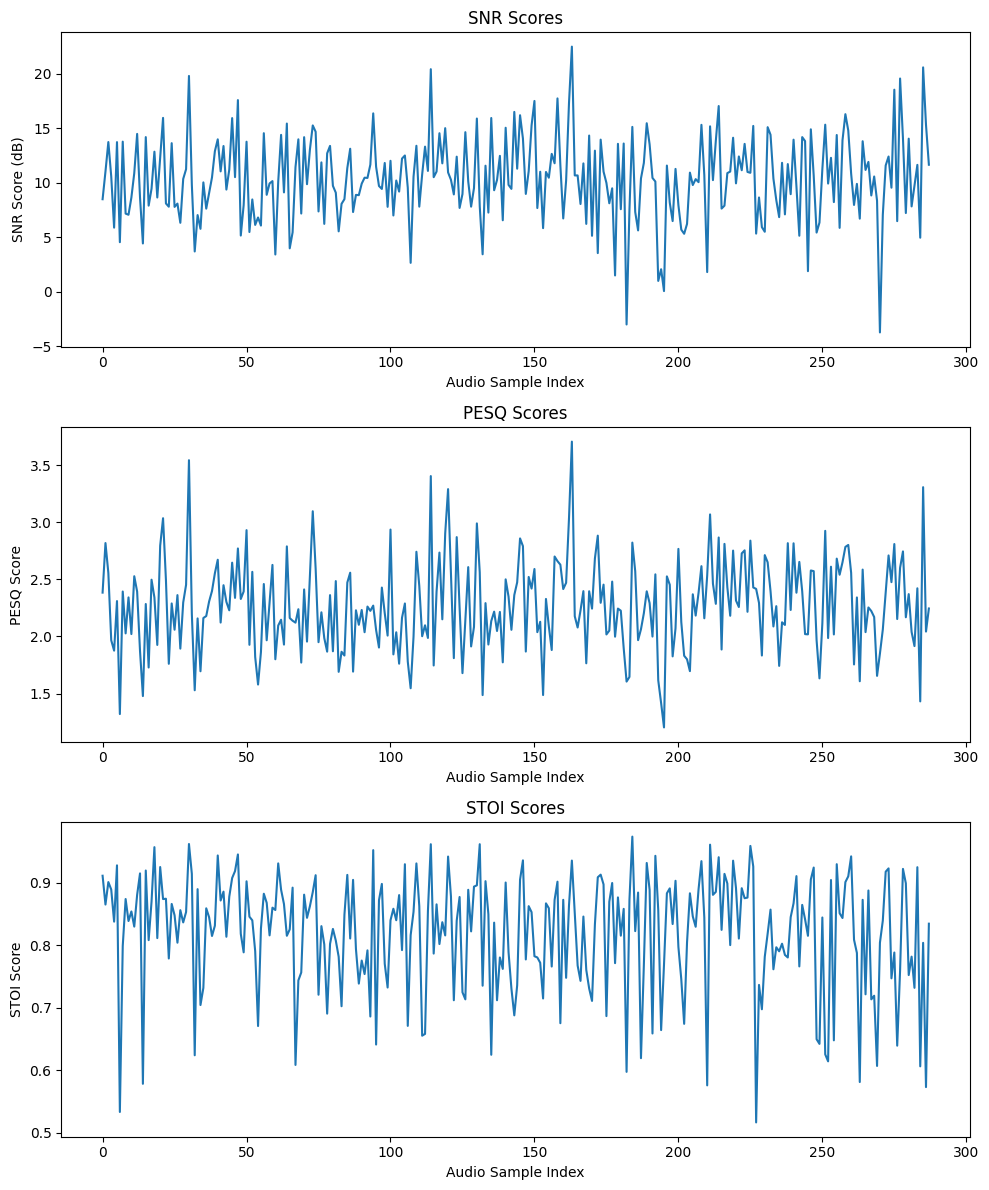

Average SNR score: 10.341978313194382 dB
Average PESQ score: 2.2685184449785285
Average STOI score: 0.8200635057329323


In [83]:
# Evaluation with SNR, PESQ, and STOI
trim_length = 28305
files_to_test = val_files
test_dataset = configure_dataset(files_to_test, train=False)
num = test_dataset.as_numpy_iterator()

snr_scores = []
pesq_scores = []
stoi_scores = []

for ind in range(len(files_to_test)):
    corr, clean = num.next()
    corr_wav = tf.signal.inverse_stft(corr[:, :, 0], frame_length=frame_length, fft_length=n_fft,
                                      frame_step=frame_step)
    clean_wav = tf.signal.inverse_stft(clean[:, :, 0], frame_length=frame_length, fft_length=n_fft,
                                       frame_step=frame_step)
    corr_amp = np.abs(corr)
    corrected_amp = model.predict(np.expand_dims(corr_amp, 0))
    corrected_spec = corrected_amp * np.exp(1j * np.angle(np.expand_dims(corr, 0)))
    corrected_wav = tf.signal.inverse_stft(corrected_spec[0, :, :, 0], frame_length=frame_length,
                                           fft_length=n_fft, frame_step=frame_step)

    # Calculate SNR
    snr_score = 10 * np.log10(np.sum(clean_wav.numpy().squeeze() ** 2) / np.sum(
        (clean_wav.numpy().squeeze() - corrected_wav.numpy().squeeze()) ** 2))
    snr_scores.append(snr_score)

    # Calculate PESQ
    pesq_score = pesq(sr, clean_wav.numpy().squeeze(), corrected_wav.numpy().squeeze(), 'nb')
    pesq_scores.append(pesq_score)

    # Calculate STOI
    stoi_score = pystoi.stoi(clean_wav.numpy().squeeze(), corrected_wav.numpy().squeeze(), sr)
    stoi_scores.append(stoi_score)

# Graphical Representation
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

axs[0].plot(snr_scores)
axs[0].set_title('SNR Scores')
axs[0].set_xlabel('Audio Sample Index')
axs[0].set_ylabel('SNR Score (dB)')

axs[1].plot(pesq_scores)
axs[1].set_title('PESQ Scores')
axs[1].set_xlabel('Audio Sample Index')
axs[1].set_ylabel('PESQ Score')

axs[2].plot(stoi_scores)
axs[2].set_title('STOI Scores')
axs[2].set_xlabel('Audio Sample Index')
axs[2].set_ylabel('STOI Score')

plt.tight_layout()
plt.show()

# Print average scores
print(f"Average SNR score: {np.mean(snr_scores)} dB")
print(f"Average PESQ score: {np.mean(pesq_scores)}")
print(f"Average STOI score: {np.mean(stoi_scores)}")

# **Distribution of Scores**

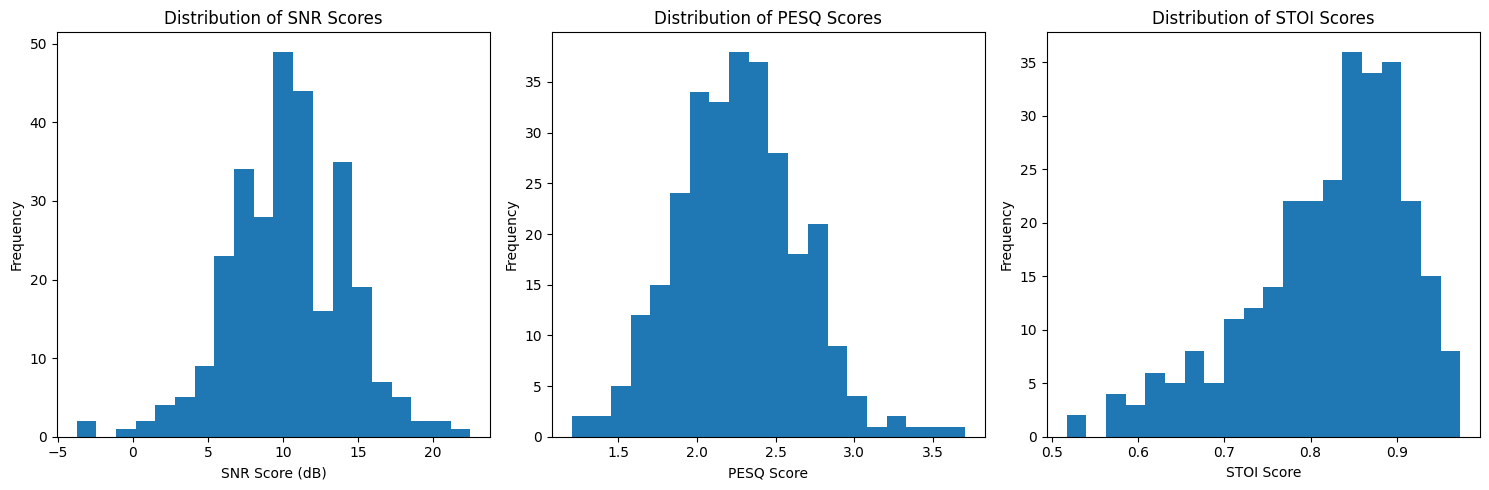

In [84]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].hist(snr_scores, bins=20)
axs[0].set_title('Distribution of SNR Scores')
axs[0].set_xlabel('SNR Score (dB)')
axs[0].set_ylabel('Frequency')

axs[1].hist(pesq_scores, bins=20)
axs[1].set_title('Distribution of PESQ Scores')
axs[1].set_xlabel('PESQ Score')
axs[1].set_ylabel('Frequency')

axs[2].hist(stoi_scores, bins=20)
axs[2].set_title('Distribution of STOI Scores')
axs[2].set_xlabel('STOI Score')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# **Scatter Plots for Correlation**

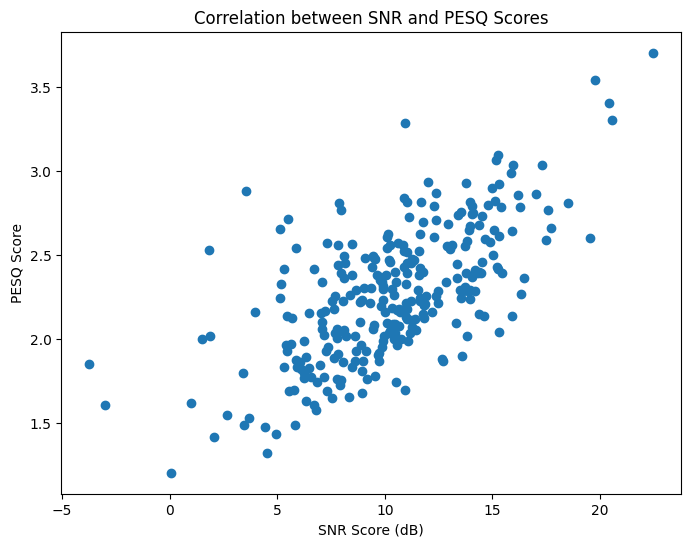

In [85]:
plt.figure(figsize=(8, 6))
plt.scatter(snr_scores, pesq_scores)
plt.title('Correlation between SNR and PESQ Scores')
plt.xlabel('SNR Score (dB)')
plt.ylabel('PESQ Score')
plt.show()

# **Time-Domain Waveform Comparison:**

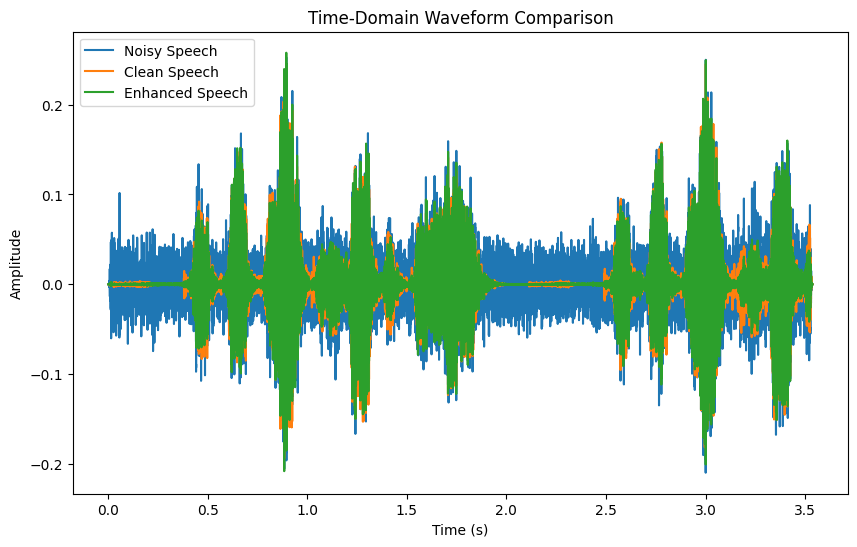

In [86]:
time_axis = np.arange(0, len(corr_wav)) / sr

plt.figure(figsize=(10, 6))
plt.plot(time_axis, corr_wav.numpy().squeeze(), label='Noisy Speech')
plt.plot(time_axis, clean_wav.numpy().squeeze(), label='Clean Speech')
plt.plot(time_axis, corrected_wav.numpy().squeeze(), label='Enhanced Speech')
plt.title('Time-Domain Waveform Comparison')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


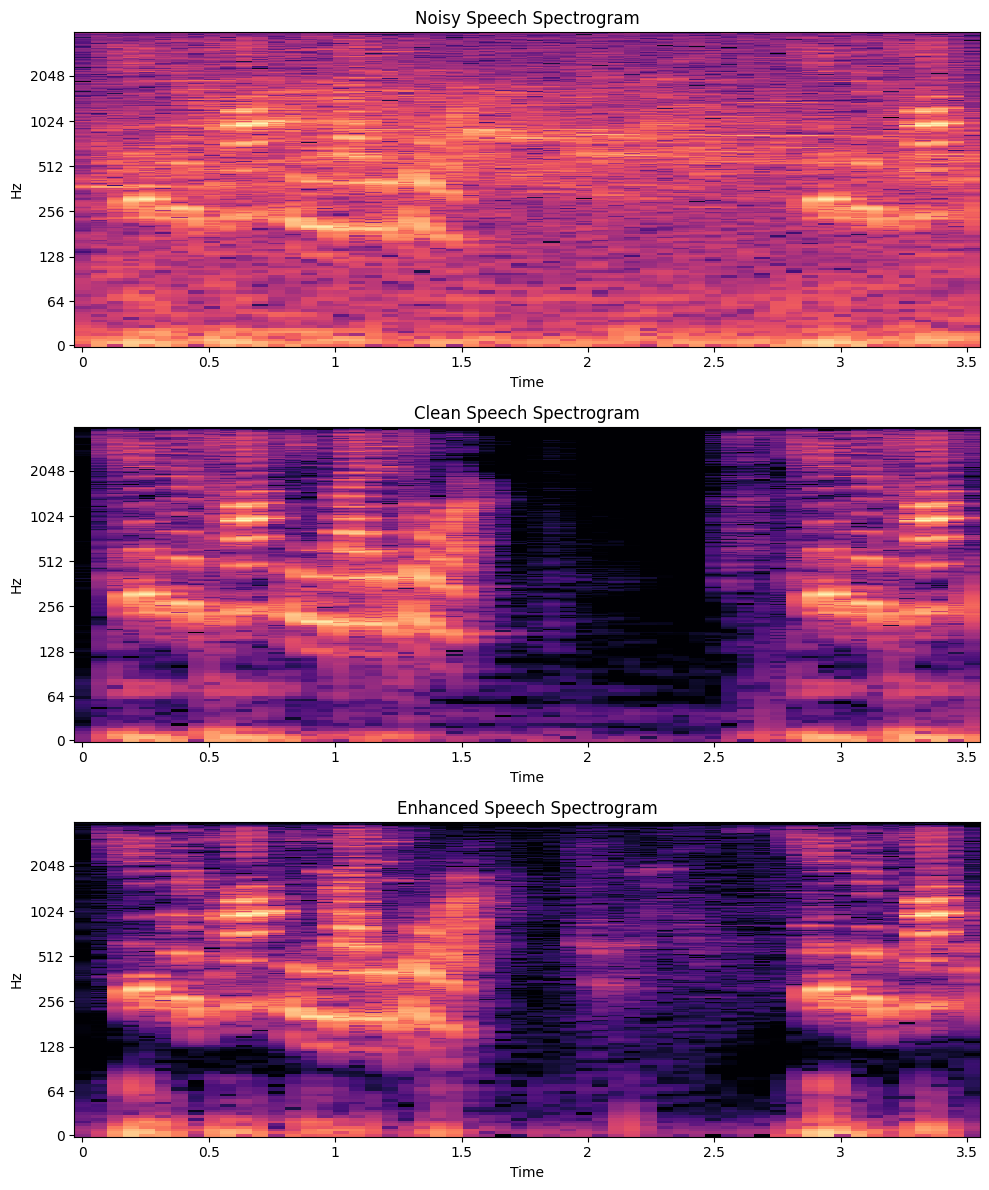

In [87]:
import librosa.display

# Reset the iterator to the beginning of the dataset
num = test_dataset.as_numpy_iterator() # Reset the iterator

# Select an audio sample from your test set
corr, clean = num.next()  # Assuming 'num' is your test dataset iterator

# Convert spectrograms back to waveforms for visualization
corr_wav = tf.signal.inverse_stft(corr[:, :, 0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
clean_wav = tf.signal.inverse_stft(clean[:, :, 0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)

# Obtain the enhanced waveform using your model - replace ... with your logic
corr_amp = np.abs(corr)
corrected_amp = model.predict(np.expand_dims(corr_amp, 0))
corrected_spec = corrected_amp * np.exp(1j * np.angle(np.expand_dims(corr, 0)))
corrected_wav = tf.signal.inverse_stft(corrected_spec[0, :, :, 0], frame_length=frame_length,
                                       fft_length=n_fft, frame_step=frame_step)

# Calculate and display spectrograms
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

D_corr = librosa.amplitude_to_db(np.abs(librosa.stft(corr_wav.numpy().squeeze())), ref=np.max)
librosa.display.specshow(D_corr, sr=sr, x_axis='time', y_axis='log', ax=axs[0])
axs[0].set_title('Noisy Speech Spectrogram')

D_clean = librosa.amplitude_to_db(np.abs(librosa.stft(clean_wav.numpy().squeeze())), ref=np.max)
librosa.display.specshow(D_clean, sr=sr, x_axis='time', y_axis='log', ax=axs[1])
axs[1].set_title('Clean Speech Spectrogram')

D_corrected = librosa.amplitude_to_db(np.abs(librosa.stft(corrected_wav.numpy().squeeze())), ref=np.max)
librosa.display.specshow(D_corrected, sr=sr, x_axis='time', y_axis='log', ax=axs[2])
axs[2].set_title('Enhanced Speech Spectrogram')

plt.tight_layout()
plt.show()

In [90]:
# Create a DataFrame
df = pd.DataFrame({
    'SNR (dB)': snr_scores,
    'PESQ': pesq_scores,
    'STOI': stoi_scores
})

# Display the table
display(df)

# Calculate and display average scores
average_scores = df.mean()
print("\nAverage Scores:")
display(average_scores)

,SNR (dB),PESQ,STOI
0,8.477808,2.383310,0.911326
1,11.017723,2.817185,0.865239
2,13.719212,2.555331,0.901189
3,10.571405,1.966566,0.889324
4,5.873076,1.875726,0.837876
...,...,...,...
283,11.628108,2.421160,0.924976
284,4.950930,1.431423,0.606413
285,20.564399,3.306168,0.803977
286,15.300294,2.042479,0.573185



Average Scores:


,0
SNR (dB),10.341978
PESQ,2.268518
STOI,0.820064


from matplotlib import pyplot as plt
df['SNR (dB)'].plot(kind='hist', bins=20, title='SNR (dB)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['PESQ'].plot(kind='hist', bins=20, title='PESQ')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['STOI'].plot(kind='hist', bins=20, title='STOI')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='SNR (dB)', y='PESQ', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='PESQ', y='STOI', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['SNR (dB)'].plot(kind='line', figsize=(8, 4), title='SNR (dB)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['PESQ'].plot(kind='line', figsize=(8, 4), title='PESQ')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['STOI'].plot(kind='line', figsize=(8, 4), title='STOI')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['SNR (dB)'].plot(kind='hist', bins=20, title='SNR (dB)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['PESQ'].plot(kind='hist', bins=20, title='PESQ')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['STOI'].plot(kind='hist', bins=20, title='STOI')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='SNR (dB)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='SNR (dB)', y='PESQ', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='PESQ', y='STOI', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['SNR (dB)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('SNR (dB)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['PESQ']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('PESQ')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['STOI']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('STOI')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_11['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['SNR (dB)'].plot(kind='line', figsize=(8, 4), title='SNR (dB)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['PESQ'].plot(kind='line', figsize=(8, 4), title='PESQ')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['STOI'].plot(kind='line', figsize=(8, 4), title='STOI')
plt.gca().spines[['top', 'right']].set_visible(False)

In [91]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1ZEGrsH3JFWM816rCQzObvI50G3qcfda54szRME4O4NE#gid=0


In [92]:
# prompt: Using dataframe df: pie

import pandas as pd
import plotly.express as px

# Assuming 'df' is your DataFrame

# Create a new DataFrame for the pie chart
pie_df = pd.DataFrame({
    'Metric': ['SNR (dB)', 'PESQ', 'STOI'],
    'Value': [df['SNR (dB)'].mean(), df['PESQ'].mean(), df['STOI'].mean()]
})

# Create the pie chart
fig = px.pie(pie_df, values='Value', names='Metric', title='Average Metric Values')
fig.show()
